# TRABAJO PRACTICO N°2

## Ejercicio 1

Basándose en los trabajos
- Performance Modelling of Imaging Service or Earth Observation Satellites with Two-dimensional Markov
Chain
- Queuing theory application in imaging service analysis for small Earth observation satellites
Se pide implementar las soluciones propuestas por los autores utilizando Cadenas de Markov, y Teoría de Colas,
considerando:

__a)__ Utilizar el generador de números al azar implementado en el Trabajo Práctico 1 para generar los números al
azar utilizados en el ejercicio (comparar los resultados con los obtenidos si se utilizan los números al azar
provistos por el lenguaje elegido).

__b)__ Probar distintos escenarios

__c) Opcional__: Comparar los resultados obtenidos, con los resultados que se obtendrían con un Generador
Congruencial Lineal de módulo $2^{32}$, multiplicador 1013904223, incremento de 1664525 y semilla igual a la
parte entera del promedio de los números de padrón de los integrantes del grupo

### <span style="color:red">Resolucion Ejercicio 1</span>

In [1]:
import time
import numpy as np

__GCL generado en el Trabajo Practico 1__

In [24]:
# PAPER 1
class xorshift:
    max64bit = (2**64) 
 
    def __init__(self,seed):
        self.seed = seed % self.max64bit

    def rand(self):
        # a=13 b=7 c=17
        # Python no tiene limite de valores para int asi que aplico modulo de 64 bits
        # para simular el comportamiento de C y tener periodo de (2^64 - 1) ----> Confirmado: Hay que imitar la implementacion del paper
        self.seed = (self.seed ^ (self.seed << 13)) % self.max64bit
        self.seed = (self.seed ^ (self.seed >> 7)) % self.max64bit
        self.seed = (self.seed ^ (self.seed << 17)) % self.max64bit

        return self.seed
    # Dividimos por el módulo para obtener valores en [0,1]
    def uniform_rand(self):
        return self.rand()/self.max64bit

    def uniform_rand_seconds_in_day(self):
        return int(self.uniform_rand() * MINUTES_IN_DAY)

In [21]:
rng = xorshift(int(time.time()))
df_rng = [rng.rand() for i in range(1000)]
df_rng_uniform = [rng.uniform_rand() for i in range(1000)]

**Generador opcional**

Generador Congruencial Lineal (GCL) de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo.

El método Lineal Congruente funciona de la siguiente manera:

$${X}_{n+1}=(aX_n + c)~mod~m, ~~~n>=0$$
$$m, ~the~ modulus, ~0<m$$
$$a, ~the~ multiplier, ~0<=a<m$$
$$c, ~the~ increment, ~0<=c<m$$
$$X_0, ~the~ starting~ value, ~0<=X_0<m$$

A partir de esto generaremos el generador GCL con los datos provistos

In [23]:
MINUTES_IN_DAY = 1440

In [10]:
class RandOp:
    
    # m:modulus
    # a:multiplier
    # c:increment
    m = 2**32
    a = 1013904223
    c = 1664525
    xn = int((97576+93956+104093+96444+98408)/5)
    
    def rand(self):
        self.xn = (self.a*self.xn + self.c)%self.m
        return self.xn
    
    # Dividimos por el módulo para obtener valores en [0,1]
    def uniform_rand(self):
        return self.rand()/self.m
    
    def uniform_rand_seconds_in_day(self):
        return int(self.uniform_rand() * MINUTES_IN_DAY)

In [6]:
randOp= RandOp()
randoms= [randOp.rand() for i in range(1000)]
randoms_uniform = [randOp.uniform_rand() for i in range(1000)]
random_seconds = [randOp.uniform_rand_seconds_in_day() for i in range(100)]

### Modelo 1: Sistema de Servicio de Captura de Imagen Pura

<div>
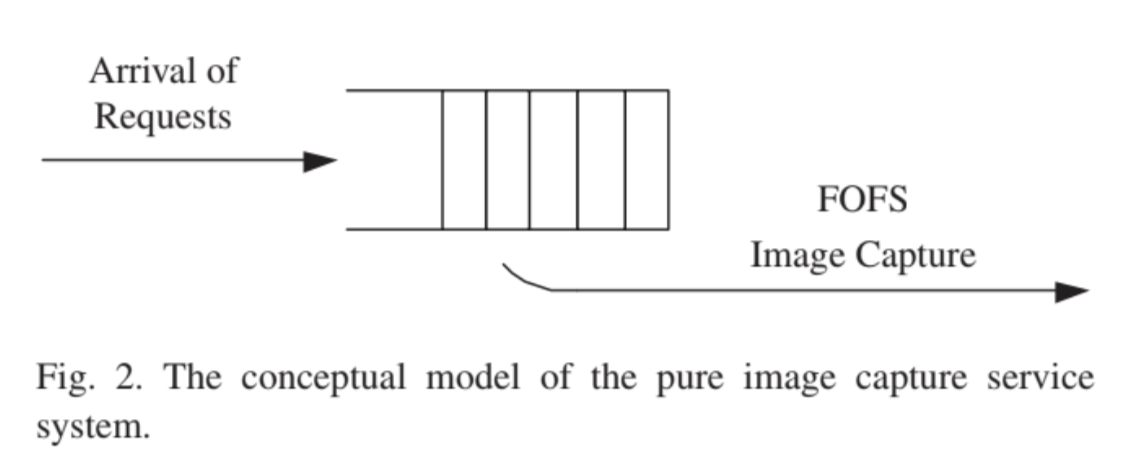
</div>

#### Hipótesis: 
- No hay límite de solicitudes
- La tasa de llegadas es conocida y la denotamos como $\lambda$
- La tasa de tiempo de servicio es conocida y la denotamos como $\mu$
- Se considera que el tiempo de captura de la imagen es despreciable respecto de el tiempo de servicio total de la request

El sistema es modelado como $M/M/1$, sabiendo que el tiempo de llegadas sigue una distribución exponencial de parámetro $\lambda$ y el tiempo de servicio sigue una distribución exponencial de parámetro $\mu$.

Planteamos entonces el siguiente sistema:

Siguiendo la disciplina FOFS (First-Opportunity-First-Served), sabemos que a todas las solicitudes que llegan al satélite que aún no han sido capturadas, se las considera y trata de la misma manera por el planificador del sistema, con un software de predicción de órbitas y calculando las ventanas de tiempo de oportunidad de visita para cada solicitud. Así, el programa siempre elige la solicitud que tenga la primera oportunidad de visitar para poder procesarla primero.

Además, sabemos que la ubicación de destino de las requests se distribuyen uniformemente en todo el mundo. Por lo tanto, se podría decir que sus coordenadas son aleatorias siguiendo una distribución uniforme.
Dicho esto podemos concluir que, si las coordenadas de cada request son aleatorias, la prioridad que le dará el satélite a cada una de ellas respecto de su posición también lo será.

Por lo tanto, simularemos con el generador XorShift propuesto en [Marsaglia, G. "Xorshift RNGs"](https://drive.google.com/file/d/1OeDTXLWPXuuIuhVsTS5ttx_yAkbfumJk/view), para cada una de las requests, una cantidad de minutos de 0 a 1440 por día; simulando el tiempo necesario para llegar a esa ubicación en el trayecto de la órbita del satélite.

Una vez desencolada una request para ser procesada, se contempla el tiempo en el que entró en la cola, el tiempo actual y el tiempo necesario para llegar hasta esa ubicación, y se calcula el tiempo de servicio total para dicha request; dando así por terminado su procesamiento. Luego, se procede con la siguiente request encolada.

Es importante destacar que, por cada unidad de tiempo, se siguen encolando requests con una distribución de Poisson según el $\lambda$ dado.

In [52]:
import heapq
import copy
import logging
import sys
from random import randint

def print_status(i):
    sys.stdout.write(f"\r {i}")
    sys.stdout.flush()
    
def python_random():
    return randint(0,MINUTES_IN_DAY)

class Satellite:
    def __init__(self, arrival_rate, random_num_function):
        self.arrival_rate = arrival_rate
        self.requests_queue = []
        self.clock = 0
        self.state_logs = [0]
        self.req_logs = []
        self.rand_op = random_num_function
        
    def push_request(self,req_dist):
        """saves req as (distance_to_target, moment_of_start)"""
        req = (req_dist, self.clock)
        heapq.heappush(self.requests_queue,req)
        #print(f"request guardada: {req}")
    
    def pop_request(self):
        req = heapq.heappop(self.requests_queue)
        travel_time = req[0]
        time_stamp_start = req[1]
                
        serv_time = self.clock - time_stamp_start + travel_time
        req_log = (time_stamp_start, self.clock + travel_time, serv_time)
        #print(f"request popeada: {req_log}, travel_time: {travel_time}")
        self.req_logs.append(req_log)

        return travel_time
        
    def number_of_req(self):
        return len(self.requests_queue)
    
    def get_poisson_reqs(self):
        number_of_arrivals = np.random.poisson(self.arrival_rate)
        new_reqs = []
        
        for i in range(number_of_arrivals):
            new_reqs.append(self.rand_op())
        
        return new_reqs
    
    def print_reqs(self):
        heap = copy.deepcopy(self.requests_queue)
        str_heap = []
        while len(heap) > 0:
            str_heap.append(str(heapq.heappop(heap)))
        
        print_status(f"Requests Queue: {' -> '.join(str_heap[:10])} ...")
    
    def print_state_logs(self):
        print('Estados:')
        state_logs = map(str, self.state_logs)
        print(" -> ".join(state_logs))
    
    def print_req_logs(self):
        print("\n \t\t ************ Requests Logs: ************ \n")
        print("N° Request \t Moment of Arrival \t Moment of Exit \t Duration(min)")
        
        for i in range(len(self.req_logs)):
            req = self.req_logs[i]
            print(f" {i} \t\t\t {req[0]} \t\t\t {req[1]} \t\t\t {req[2]} ")

    def print_service_rate(self,days):
        print(f"\nService Rate Per Day: {len(self.req_logs)/days}")
    
    def get_new_reqs(self):
        new_reqs = self.get_poisson_reqs()
        #print(f"new req: {new_reqs}")
        for req in new_reqs:
            self.push_request(req)
            self.print_reqs()
    
    def orbit_days(self, days):
        
        i = 0
        while i < days * SECONDS_IN_DAY:
            
            #print(f"\ni: {i}")
            #print(f"clock: {self.clock}")
            
            self.clock = i
            serv_time = 1

            while self.number_of_req() == 0:
                #print_status(i)
                self.get_new_reqs()
                i += 1
                
            serv_time = self.pop_request()
            
            while serv_time > 0:
                #print_status(i)
                #print(f"\ni: {i}")
                #print(f"clock: {self.clock}")
            
                self.get_new_reqs()
                if serv_time > 1:
                    i += 1
                serv_time -= 1
            
            i+= 1
                
        #self.print_state_logs()
        self.print_req_logs()
        self.print_service_rate(days)

### Xorshift
Corremos el programa con nuestro generador $xorshift$ del trabajo práctico 1.

In [53]:
sat = Satellite(2,rng.uniform_rand_seconds_in_day)
sat.orbit_days(1)

 Requests Queue: (7, 1435) -> (34, 0) -> (34, 702) -> (34, 864) -> (34, 995) -> (34, 1253) -> (35, 0) -> (35, 0) -> (35, 677) -> (35, 1044) ....
 		 ************ Requests Logs: ************ 

N° Request 	 Moment of Arrival 	 Moment of Exit 	 Duration(min)
 0 			 0 			 490 			 490 
 1 			 0 			 492 			 492 
 2 			 0 			 493 			 493 
 3 			 0 			 495 			 495 
 4 			 0 			 498 			 498 
 5 			 0 			 501 			 501 
 6 			 0 			 505 			 505 
 7 			 0 			 510 			 510 
 8 			 0 			 516 			 516 
 9 			 0 			 525 			 525 
 10 			 516 			 532 			 16 
 11 			 0 			 543 			 543 
 12 			 0 			 556 			 556 
 13 			 0 			 569 			 569 
 14 			 556 			 577 			 21 
 15 			 556 			 589 			 33 
 16 			 0 			 604 			 604 
 17 			 543 			 624 			 81 
 18 			 604 			 633 			 29 
 19 			 0 			 655 			 655 
 20 			 633 			 677 			 44 
 21 			 501 			 702 			 201 
 22 			 677 			 719 			 42 
 23 			 702 			 727 			 25 
 24 			 702 			 747 			 45 
 25 			 655 			 772 			 117 
 26 			 747 			 788 			 41 
 27 			 0 	

### Random.randint
Corremos el programa con el generador de número random de Python

In [46]:
sat2 = Satellite(2,python_random)
sat2.orbit_days(1)

 Reqs: (26, 1428) -> (33, 794) -> (33, 1118) -> (33, 1205) -> (33, 1385) -> (34, 0) -> (34, 0) -> (34, 794) -> (34, 1127) -> (34, 1205) ...
 ************ Requests Logs: ************ 
N° Request 	 Moment of Arrival 	 Moment of Exit 	 Duration(min)
 0 			 0 			 462 			 462 
 1 			 0 			 467 			 467 
 2 			 0 			 471 			 471 
 3 			 0 			 475 			 475 
 4 			 0 			 482 			 482 
 5 			 0 			 490 			 490 
 6 			 0 			 506 			 506 
 7 			 0 			 522 			 522 
 8 			 0 			 539 			 539 
 9 			 0 			 556 			 556 
 10 			 0 			 574 			 574 
 11 			 556 			 590 			 34 
 12 			 574 			 593 			 19 
 13 			 0 			 612 			 612 
 14 			 593 			 620 			 27 
 15 			 0 			 640 			 640 
 16 			 0 			 662 			 662 
 17 			 640 			 686 			 46 
 18 			 574 			 711 			 137 
 19 			 686 			 722 			 36 
 20 			 0 			 748 			 748 
 21 			 539 			 774 			 235 
 22 			 748 			 794 			 46 
 23 			 662 			 821 			 159 
 24 			 794 			 826 			 32 
 25 			 794 			 842 			 48 
 26 			 794 			 858 			 64 
 27 			 826 			 885

### Generador de Números Opcional
Corremos el programa con el generador de números opcional

In [47]:
sat2 = Satellite(2,randOp.uniform_rand_seconds_in_day)
sat2.orbit_days(1)

 Reqs: (17, 1425) -> (24, 1395) -> (36, 505) -> (36, 615) -> (36, 1131) -> (37, 0) -> (38, 0) -> (38, 1326) -> (39, 196) -> (39, 1319) ...
 ************ Requests Logs: ************ 
N° Request 	 Moment of Arrival 	 Moment of Exit 	 Duration(min)
 0 			 0 			 120 			 120 
 1 			 0 			 132 			 132 
 2 			 0 			 146 			 146 
 3 			 121 			 162 			 41 
 4 			 121 			 178 			 57 
 5 			 146 			 196 			 50 
 6 			 178 			 212 			 34 
 7 			 196 			 222 			 26 
 8 			 212 			 229 			 17 
 9 			 178 			 247 			 69 
 10 			 229 			 256 			 27 
 11 			 229 			 267 			 38 
 12 			 247 			 288 			 41 
 13 			 267 			 289 			 22 
 14 			 121 			 311 			 190 
 15 			 289 			 333 			 44 
 16 			 311 			 344 			 33 
 17 			 0 			 367 			 367 
 18 			 344 			 373 			 29 
 19 			 367 			 392 			 25 
 20 			 247 			 415 			 168 
 21 			 256 			 439 			 183 
 22 			 415 			 449 			 34 
 23 			 415 			 460 			 45 
 24 			 449 			 466 			 17 
 25 			 460 			 467 			 7 
 26 			 415 			 479 			 64 
 27 			 31

## Ejercicio 2
Utilizar Simpy para simular una sección del ejercicio 1 a elección

### <span style="color:red">Resolucion Ejercicio 2</span>

## Ejercicio 3
Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).
Se determinó que en 10 milisegundos existe una probabilidad p =1/40 que llegue una nueva solicitud y una probabilidad q = 1/30 que una solicitud termine de ser procesada y deje el sistema.

Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser
procesadas como la solicitud que está siendo procesada.

__a.__ Determine la matriz de transición de estados explicando cómo se obtiene la misma.

__b.__ Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el
sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.

__c.__ Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

__d.__ Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

__e.__ Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

### <span style="color:red">Resolucion Ejercicio 3</span>

__a.__ Determine la matriz de transición de estados explicando cómo se obtiene la misma:

- _Cadenas de Markov_

Es un tipo particular de un proceso de Markov en el cual la probabilidad de que ocurra un
evento depende solamente del evento inmediatamente anterior.
Esta memoria "a 1 solo paso" es la propiedad Markoviana y se puede escribir como:

$$
P(X_{n+1}=j/X_n=i_n \bigcap X_{n-1}=i_{n-1} \bigcap ... \bigcap x_0=i_0)= P(X_{n+1}=j/X{n}=i)
$$


- _Probabilidades de transiciones_

Es la probabilidad de que en el futuro tengamos j sabiendo que en el presente tenemos i:
$$P [X_{n+1} = j /X_n = i ]= p_{ij}$$

- _Matriz de transiciones_

Representa todas las transiciones i − > j que componen a la cadena de Markov:

$$P = \begin{bmatrix}
P_{00} & P_{01} & ... & P_{0j}\\
P_{10} & P_{11} & ... & P_{1j}\\
... & ... & ... & ... \\
P_{i0} & P_{i1} & ... & P_{ij}\\
\end{bmatrix}=
\begin{bmatrix}
P [X_{n+1} = 0 /X_n = 0] & P [X_{n+1} = 1 /X_n = 0] & ... & P [X_{n+1} = j /X_n = 0]\\
P [X_{n+1} = 0 /X_n = 1] & P [X_{n+1} = 1 /X_n = 1] & ... & P [X_{n+1} = j /X_n = 1]\\
... & ... & ... & ...\\
P [X_{n+1} = 0 /X_n = i] & P [X_{n+1} = 1 /X_n = i] & ... & P [X_{n+1} = j /X_n = i]\\
\end{bmatrix}$$

Se debe notar que la sumatoria de los valores de cada fila de esta matriz suman 1:
$$
\sum_j P [X_{n+1} = j /X_n = i ] = \sum_j p_{ij} = 1 .
$$

En este caso la matriz de transción de estados se puede obtener si pensamos a cada estado como la suma entre la cantidad de solicitudes esperando ser procesadas más la solicitud siendo procesada.

Suponiendo que en 10 milisegundos no puede arribar más de 1 solicitud ni que más de 1 solicitud salga del sistema ni que una misma solicitud entre y salga en la misma fracción, podemos definir 3 transiciones posibles por fracción de tiempo para cada estado:

- la cantidad total de solicitudes __aumenta en 1__  si arriba una solicitud al servidor y no sale ninguna.


- la cantidad total de solicitudes __disminuye en 1__  si una solicitud deja el sistema y no ingresa ninguna.


- la cantidad total de solicitudes __se mantiene igual__ si:

    - una solicitud llega al servidor y otra sale
    
    - no llega ni sale ninguna solicitud del servidor

Teniendo las siguientes probabilidades:

Probabilidad de arribo(Pa)= 1/40

Probabilidad de salida(Ps) = 1/30

Pn-1 = Probabilidad de que no arribe ninguna solicitud (1-Pa) * Probabilidad de que egrese una solicitud del sistema (Ps) 

Pn+1 = Probabilidad de que no egrese ninguna solicitud (1-Ps) * Probabilidad de que arribe una solicitud al sistema (Pa)

Pn = Probabilidad de que no egrese ni ingrese ninguna solicitud (1-Ps) * (1-Pa) + Probabilidad de que ingrese una solicitud y egrese otra (Ps * Pa)

Cuando n=0 es un caso particular ya que al no haber niguna solicitud en el sistema (ni siendo procesada ni en cola) solo se puede avanzar hacia el estado n=1 con probabilidad Pa y mantenerse en n=0 con probabilidad (1-Pa) 

Visualizamos de la siguiente manera:

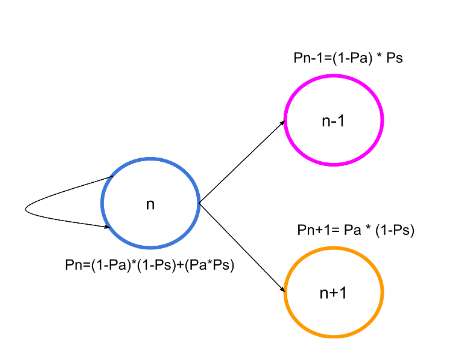

La matriz de transicion de estados queda de la forma:

$$P = \begin{bmatrix}
1-P_{a} & P_{a} & 0 & 0 & ...\\
P_{n-1} & P_{n} & P_{n+1} & 0 & ...\\
0 & P_{n-1} & P_{n} & P_{n+1} & ...\\
0 & 0 & P_{n-1} & P_{n} & ...\\
... & ... & ... & ... & ... \\
\end{bmatrix}$$

con n: cantidad máxima de solicitudes que puede procesar el sistema

__b.__ Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.

In [36]:
import random as rn
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def simulacion(tiempo,step):
    Pa = 1/40
    Ps = 1/30
    estado = 0
    solicitudes_totales = 0
    tiempos = []
    cant_solicitudes_x_fraccion = []
    tiempo_sin_solicitudes = 0
    for x in range(0, tiempo * 1000, step):
        u = rn.random()
        if (estado == 0):
            if (u > 1-Pa): #ingresa solicitud
                solicitudes_totales += 1
                estado += 1
            else:
                tiempo_sin_solicitudes += step
        else:
            if (u <= (Ps*(1-Pa))):#egresa solicitud
                estado -= 1
            elif (u > 1 - (Pa*(1-Ps))): #ingresa solicitud
                solicitudes_totales += 1
                estado += 1
        tiempos.append(x)
        cant_solicitudes_x_fraccion.append(estado)   
        
    return tiempos, cant_solicitudes_x_fraccion, solicitudes_totales, tiempo_sin_solicitudes

In [38]:
tiempos, cant_solicitudes_x_fraccion, total_solicitudes_procesadas, tiempo_sin_solicitudes = simulacion(1000, 10)

__c.__ Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.


Text(0, 0.5, 'Cantidad de Solicitudes')

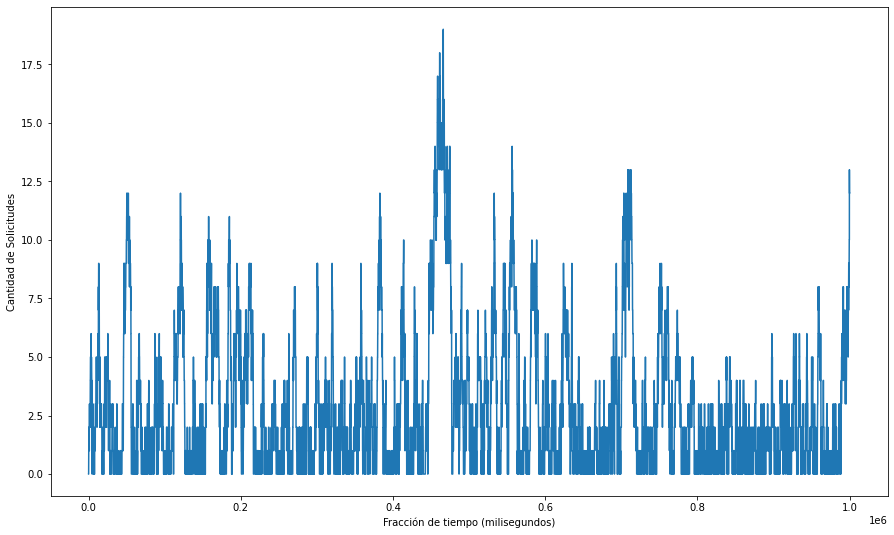

In [39]:
print("c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.")
plt.figure(figsize=(15,9))
plt.plot(tiempos,cant_solicitudes_x_fraccion)
plt.xlabel('Fracción de tiempo (milisegundos)')
plt.ylabel('Cantidad de Solicitudes')

El sistema no llega a saturarse (el máximo de solicitudes se encuentra alrededor de 19 cuando el máximo soportado es 30), esto podría deberse a que la probabilidad de egreso del sistema es mayor a la probabilidad de arribo

__d.__ Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado


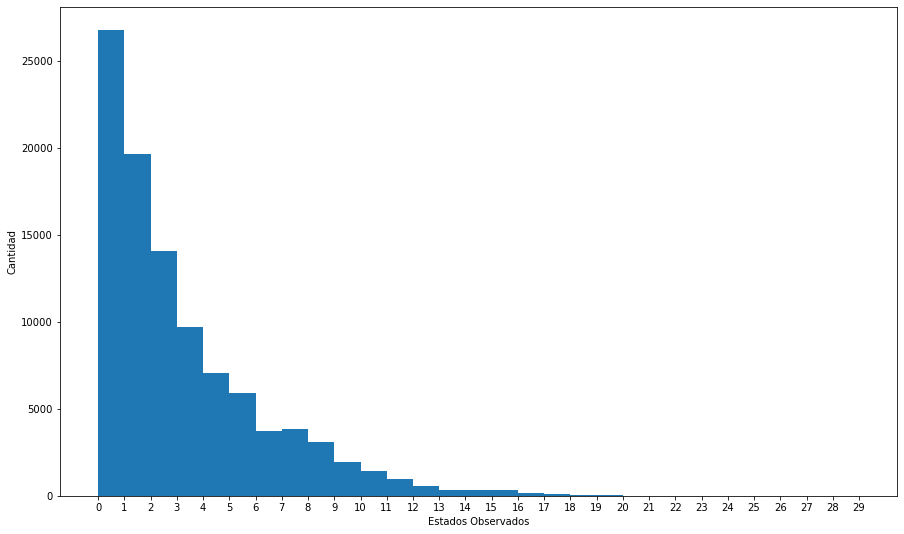

In [40]:
print("d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado")
plt.figure(figsize=(15,9))
plt.hist(cant_solicitudes_x_fraccion,bins=range(0, 30, 1))
plt.xlabel('Estados Observados')
plt.ylabel('Cantidad')
plt.xticks(np.arange(0, 30, step=1))
plt.show()

__e.__ Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

Consideramos que el servidor no procesa solicitudes en aquellos momentos en los cuales el estado = 0.

Pasamos el tiempo en el que el sistema no procesó solicitudes a segundos y calculamos el porcentaje que representa respecto del total de 1000 segundos

In [41]:
print(str(((tiempo_sin_solicitudes / 1000) * 100) / 1000) + "%")

26.095%
